# Victorian Era Authorship Attribution

*Written by: [Sweta Karlekar](https://rostr.disney.com/people/1c48fc86dfaf4c04a245c70e4d3d106a)*

**TASK**: Given text samples, predict authorship from 45 available authors.  

Dataset information:  English language writing authors, authors that have enough books available (at least 5), 19th century authors. With these criteria 45 authors have been selected and their books were queried through Big Query Gdelt database. The dataset was cleaned before being published online at the link below. Data is presented in labeled format, with an attributed author for each given text. 

**This project:**
- **Clusters data to understand relationships between author works:**
    - Runs K-Means *(K=45)* clustering on term/feature vectors to understand themes discussed in various works 
    - Visualizes above clustering technique with author tags rather than feature vectors to visualize which authors' works are commonly grouped 
    - Runs K-Means *(K=10)* clustering on vectorized author profiles to find similar authors 
- **Classifies data based on authorship tag:**
    - Runs Naive Bayes classification
    - Runs Linear SVM classification 
    - Runs Multi-Layer Perceptron over text classification

**Data Information:**
 - Data was randomly shuffled and 10% of data was set aside as held-out test set. 

**Results:**
- Achieves Homogeneity: 0.2, Completeness: 0.3, V-measure: 0.2 with K-Means Clustering 
- Achieves 73% accuracy with Naive Bayes classification 
- Achieves 98% accuracy with Linear SVM classification 
- Achieves 98% accuracy with Multi-Layer Perceptron

Link: https://archive.ics.uci.edu/ml/datasets/Victorian+Era+Authorship+Attribution



In [1]:
!pip install yellowbrick 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import stop_words
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

## Loading Data 

The first thing we do is load the data, which has been saved in a csv file in the same folder under the name "train_data.csv". To load the data, we use the read_csv() function from the pandas module and select the "text" and "author" column. Then, using the dropna() function, we remove all instances in which either the text or the author is missing. Next, we shuffle the data using the reindex() function. Finally, we return a list of unique labels, the text instances (x_raw), and corresponding labels (y_raw). 

In [3]:
def load_data(filename): 
    #get the selected columns out of the dataset and shuffle
    df = pd.read_csv(filename, encoding="ISO-8859-1")
    selected = ['text', 'author']
    df = df.dropna(axis=0, how='any', subset=selected)
    df = df.reindex(np.random.permutation(df.index)) #shuffle 
    labels = sorted(list(set(df[selected[1]].tolist())))
   
    x_raw = df[selected[0]].tolist()
    y_raw = df[selected[1]].tolist()

    return x_raw, y_raw, labels

Here we call the load_data() function on our training file and save the values that are returned. Next, in order to check our return values, we print out samples of the loaded data. 

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00454/dataset.zip
!unzip dataset.zip 

In [5]:
train_file = 'dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv'
x_raw, y_raw, y_labels = load_data(train_file)

#print samples of loaded data
NUM_SAMPLES = 5
for i in range(NUM_SAMPLES): 
    print("{}..., {}".format(x_raw[i][0:50], y_raw[i]))

on monday i am sure of it ay monday morning before..., 9
but nobody ever said so oh yes they is it true vai..., 15
reading a book the picture of good humor and repos..., 38
once what you have done i would rather know the pa..., 14
dreamed of her all and now f be he met her at the ..., 42


Here we plot the number of stories in the dataset per author. We see that some authors are overrepresented in the dataset. Because of this, we will require further analysis into our results to ensure our models do not overfit. 

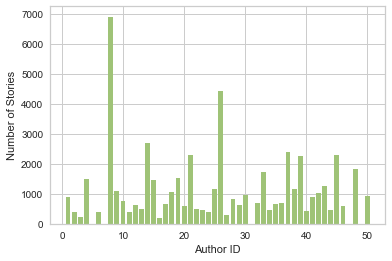

In [6]:
dictY = {}
for x in range(len(y_raw)): 
    if(y_raw[x] in dictY): 
        dictY[y_raw[x]] += 1
    else: 
        dictY[y_raw[x]] = 0 
plt.bar(list(dictY.keys()), dictY.values(), color='g')
plt.ylabel('Number of Stories')
plt.xlabel('Author ID')
plt.show()

## Vectorizing and Visualizing Data 

Using sklearn's TfidfVectorizer(), we can produce sparse representation of the word counts. TfidfVectorizer uses a in-memory vocabulary (a python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus (~from sci-kit learn documentation). While CountVectorizers are commonly used, TfidfVectorizers are preferred for large text corpuses in which some words are very present (i.e. stop words) and carry little meaningful information about the contents of the document. Instead, using term-frequency (*tf* in *tfidf*) times the inverse document-frequency (*idf* in *tfidf*) allows for features that are more representative of the content of the documents. 

After vectorizing, we can graph the frequency distribution of the top 50 tokens with standard English stop words removed (*graph_frequencies()* code from [Reuters-21578 Text Categorization.ipynb](https://gitlab.disney.com/ets/jupyter-ml-rampup/blob/master/reuters_text_categorization/Reuters-21578%20Text%20Categorization.ipynb)). Then we graph the frequences using FreqDistVisualizer from yellowbrick. 

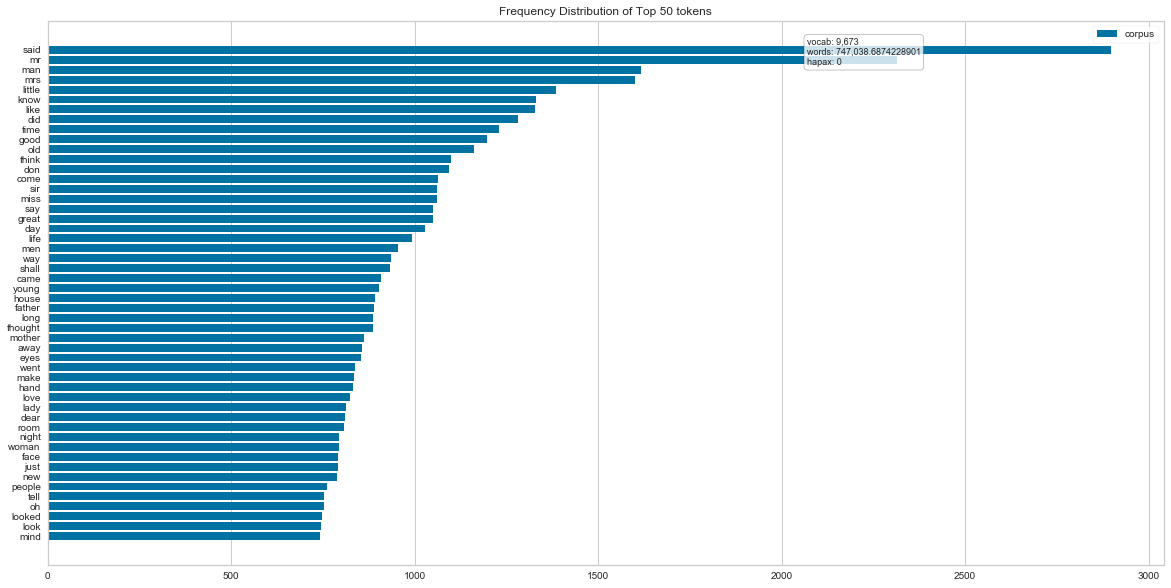

In [7]:
def graph_frequencies(matrix, features):
    fig, ax = plt.subplots(figsize=(20, 10))
    visualizer = FreqDistVisualizer(features=features, ax=ax)
    visualizer.fit(matrix)
    visualizer.poof()
    plt.close(fig)

#vectorize data (put it into token form to extract features)
vectorizer = TfidfVectorizer(stop_words = "english")
bodyMatrix = vectorizer.fit_transform(x_raw)

#graph the features to find out frequency distribution 
bodyFeatures = vectorizer.get_feature_names()
graph_frequencies(bodyMatrix, bodyFeatures)

In [8]:
print("n_samples: %d, n_features: %d" % bodyMatrix.shape)

n_samples: 53678, n_features: 9673


## K-Means Clustering 

K-Means clustering is one of the fastest clustering algorithms available. We use clustering to see if words from these text samples fall into distinct categories, or if they are all very similar. Features were clustered into 45 distinct groups as there are 45 true distinct authors. We do this under the assumption that different authors have different writing styles and write in different topics, however this may not always be the case. The inertia (sum of squared distances of samples to their closest cluster center) decreases with each iteration through the run time. The default for MiniBatchKMeans is stop if the inertia does not decrease after 10 iterations (called early-stopping). The n_init parameter allows the MiniBatch algorithm to run *N* times (N = 20) and choose the best run with the least inertia to report results. This step is important because K-Means is susceptible to falling into local minima, which is why it is important to run multiple times. The run time is also printed for future reference. 

### Feature Clustering 

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
import sys
from time import time

true_k = len(y_labels) #the true number of clusters should be the number of unique authors
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=20, random_state = 42, compute_labels = True) #make it verbose so we know it's working
print("Clustering sparse data with %s" % km)
t0 = time() #record start time to document the total time it took to run
km.fit(bodyMatrix, y_raw)
print("done in %0.3fs" % (time() - t0)) #print total run time
print()

Clustering sparse data with MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=45,
        n_init=20, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 5.552s



Below are the most common evaluation techniques for clustering. 

- Homogeneity: a measure of if clusters contain only data points that are members of a single class 
- Completeness: a measure of if all data points that are members of a given class are elements of the same cluster 
- V-measure: harmonic mean between homogeneity and completeness 
- Adjusted Rand-Index: computes similarity measure between two clusterings by considering all pairs of samples and county pairs that are assigned in the same or different cluster in the predicted and true clustering (i.e. similarity scores that measure if the labelings are better than random labelings)
- Silhouette Coefficient: mean intra-cluster distance and mean nearest-cluster distance, higher values indicate very distinct clusters with no overlap, values near zero indicate overlapping clusters, and negative values indicate samples that are assigned to the wrong cluster

We also print out the top terms of each cluster to visualize which concepts and features are grouped together. 

In [10]:
#print k-means evaluation results 
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_raw, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_raw, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y_raw, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y_raw, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(bodyMatrix, km.labels_, sample_size=1000))
print()

#print top terms in each cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end=', ')
    print()

Homogeneity: 0.176
Completeness: 0.315
V-measure: 0.226
Adjusted Rand-Index: 0.043
Silhouette Coefficient: 0.005

Top terms per cluster:
Cluster 0: city,  significance,  gambling,  chief,  newspaper,  connection,  concerned,  editor,  state,  man, 
Cluster 1: exertion,  eloquence,  caesar,  jf,  philosophers,  roman,  rome,  young,  extracted,  men, 
Cluster 2: thou,  thy,  thee,  said,  hast,  art,  man,  shall,  god,  thine, 
Cluster 3: mother,  mr,  street,  husband,  influenced,  mrs,  sunlight,  emotions,  rested,  group, 
Cluster 4: year,  fu,  new,  decorated,  temples,  prayers,  streets,  boats,  custom,  debts, 
Cluster 5: mr,  said,  sir,  mrs,  know,  man,  don,  little,  say,  old, 
Cluster 6: thou,  hast,  rt,  things,  virtue,  thine,  ex,  di,  si,  following, 
Cluster 7: jane,  mr,  mrs,  miss,  letters,  elizabeth,  mother,  edward,  letter,  mary, 
Cluster 8: said,  man,  like,  little,  did,  know,  don,  old,  come,  time, 
Cluster 9: sir,  maria,  nt,  tho,  idle,

### Author Label Clustering 

Print out above clusters with author labels rather than term/feature labels to investigate which authors are clustered together often. 

In [11]:
print("Cluster with Author Labels:")
k_means_labels = km.labels_
dictLabels = dict((author,[]) for author in km.labels_)
NUM_SAMPLES = len(y_raw)
for k in range(NUM_SAMPLES): 
    dictLabels[km.labels_[k]].append(y_raw[k])
for key, value in sorted(dictLabels.items()): 
    print("\nCluster {}: {}".format(key, value[:100]))

Cluster with Author Labels:

Cluster 0: [43, 43]

Cluster 1: [29]

Cluster 2: [39, 18, 41, 9, 28, 9, 33, 9, 45, 9, 48, 39, 33, 45, 41, 25, 45, 45, 37, 9, 39, 41, 27, 50, 39, 35, 37, 18, 45, 39, 28, 4, 41, 15, 13, 4, 24, 33, 18, 45, 45, 45, 44, 39, 37, 45, 41, 37, 41, 48, 39, 39, 41, 45, 18, 39, 39, 41, 18, 15, 4, 37, 28, 45, 9, 23, 39, 39, 4, 28, 14, 45, 24, 45, 28, 45, 4, 39, 21, 39, 4, 45, 21, 39, 23, 2, 37, 39, 37, 45, 37, 45, 2, 15, 39, 39, 39, 13, 28, 44]

Cluster 3: [14, 14, 14, 14]

Cluster 4: [20]

Cluster 5: [38, 8, 8, 8, 22, 25, 42, 9, 45, 8, 8, 8, 43, 8, 14, 8, 8, 8, 8, 36, 8, 26, 36, 14, 8, 8, 12, 26, 8, 8, 8, 8, 22, 42, 8, 12, 8, 8, 27, 14, 8, 8, 33, 8, 8, 8, 14, 8, 8, 8, 14, 9, 9, 25, 8, 15, 24, 30, 8, 8, 9, 8, 38, 8, 8, 8, 36, 8, 8, 8, 8, 8, 8, 8, 8, 38, 8, 8, 8, 26, 1, 25, 8, 14, 25, 46, 9, 8, 14, 8, 26, 8, 9, 14, 8, 8, 15, 8, 8, 25]

Cluster 6: [28]

Cluster 7: [26, 6, 26, 26, 26, 6, 26, 26, 26, 6, 26, 8, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 6, 26, 26, 26, 2

Above we see some Author IDs co-occur frequently in some clusters. We try to explain these co-occurences by researching the authors and their writing styles to understand what kinds of topics, literary styles, and influences each author used. 

26 and 6 - Jane Austen and Catherine Maria Sedgewick
Interestingly, Sedgewick was highly influenced by Austen's work: "Born only thirteen years after the Revolutionary War began, Catherine Maria Sedgwick was one of her day’s most popular novelists. Her literary career began only a decade after Jane Austen’s, and the authors’ works are quite similar. Much of the volume is taken up with Austenesque love triangles."
<https://historicalnovelsociety.org/reviews/the-linwoods/>

8 and 21 - Charles Dickens and Jack London 
Both Jack London and Charles Dickens worked in very similar topics, namely exploring the middle and lower class worker in the age of modern urbanization and industrialization. “In both liberal humanist and Marxist approaches to literature in adult education up to 1945, moves were made to extend the canon of works studied to include texts of particular interest to working-class readers - for example the work of Charles Dickens and Jack London.” 
The Cambridge History of Literary Criticism: Volume 9, Twentieth-Century (https://books.google.com/books?id=NCEpn3KxxT4C&pg=PA158&lpg=PA158&dq=charles+dickens+and+%22jack+london%22+lower+class+workers&source=bl&ots=GBDnrywwUL&sig=3TYDim-YEJ7tIQh3JvPjfNqvAVM&hl=en&sa=X&ved=2ahUKEwj1ueiOiqXdAhURDHwKHX4HARYQ6AEwBHoECAUQAQ#v=onepage&q=charles%20dickens%20and%20%22jack%20london%22%20lower%20class%20workers&f=false)

38 and 39 - Robert Louis Stevenson and Rudyard Kipling 
“Stevenson corresponded with and was admired by other authors of his time… Other authors who admired him greatly but with whom he didn’t enjoy a personal relationship included…Rudyard Kipling.”
https://stevensonmuseum.org/robert-louis-stevenson/the-times/

39 and 21 - Rudyard Kipling and Jack London
“As for literary influences, Rudyard Kipling was London’s idol. He reveled in the heroics and racial overtones of the English giant’s writing. Early in his career he rewrote much of Kipling’s work longhand, in an effort to capture some of the style. In one of his letters he acknowledged his indebtedness, writing: “As for myself, there is no end of Kipling in my work, . . . I would never have possibly written anywhere near the way I did had Kipling never been.””
https://www.counter-currents.com/2011/07/the-soul-of-jack-london-part-1/

19, 37,  and 21 - Horace Greeley, Thomas Carlyle, Jack London 
All wrote about life “tramps, criminals, and prostitutes” and were features in Book III: The Outcast by Upton Sinclair as an anthology of the literature of social protest. “The life of the underworld, of those thrown upon the scrap-heap of the modern industrial machine”. 
https://www.bartleby.com/71/index3.html

19 and 37 - Horace Greeley and Thomas Carlyle
“The two most influential books for Greeley were Thomas Carlyle’s Past and Present, which was a gift from Emerson, and William Atkinson’s (1840)Principles of Political Economy; or the Laws of the Formation of National Wealth, Developed by Means of the Christian Law of Government. Together, they represent Greeley’s twin interests in radical reform of concentrated wealth among elite landowner as reflected in Carlyle, and dignifying labor through property ownership as advanced in Atkinson.”
http://journals.sagepub.com/doi/full/10.1177/1522637916687321


### Vectorized Author Profiles

We created author profiles by concatenating all of the author's work together and then vectorizing each large body of work to create vector profiles of each author. We then clustered these profile vectors to visualize patterns in author patterns. 

In [12]:
#combine and concatenate all works by the same author 
dictAuthorWorks = dict((work,"") for work in y_raw)
for x in range(len(x_raw)):
    dictAuthorWorks[y_raw[x]] += x_raw[x]
x_raw_author_prof = list(dictAuthorWorks.values()) #list of author works with same index as IDs 
y_raw_author_prof = list(dictAuthorWorks.keys()) #list of Author IDs

print("Author works concatenated.")
print("Number of concatenated works: {}".format(len(x_raw_author_prof)))
print("Number of authors: {}".format(len(y_raw_author_prof)))

Author works concatenated.
Number of concatenated works: 45
Number of authors: 45


In [13]:
#vectorize data to obtain features of each author and create vectorized author profile 
vectorizerAuthor = TfidfVectorizer(stop_words = "english")
authorMatrix = vectorizerAuthor.fit_transform(x_raw_author_prof)
authorFeatures = vectorizerAuthor.get_feature_names()

print("Author vectorized profiles created.")

Author vectorized profiles created.


### Find Closest Authors
After creating vectorized author profiles, we can find the closest authors to any individual using cosine similarity. We use sklearn's linear kernel and then splice the vector of the desginated author. We can then find the closest authors in relation to the spliced vector by sorting the rest of the authorMatrix and then returning the IDs of the closest authors. 

In [14]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances

def findClosest(ID, N=5): 
    index = y_raw_author_prof.index(ID)
    temp = authorMatrix[index:index+1]
    cosine_similarities = linear_kernel(temp, authorMatrix).flatten()
    related_auth_indices = cosine_similarities.argsort()[:(-1*(N+2)):-1]
    closestAuthors = [y_raw_author_prof[x] for x in related_auth_indices[1:]]
    return closestAuthors

findClosest(26, N=6) #input Author ID to see N closest neighbors 
#26 = Jane Austen, 6 = Catherine Sedgewick, we see here that 6 is included in closest neighbors to 26

[25, 1, 14, 6, 8, 12]

### Author Profile Clustering 

Using the features from each author profile, we cluster authors and investigate the inertia and stability of using various NUM_CLUSTER values. 

In [37]:
NUM_CLUSTERS = 10
kmAuthor = MiniBatchKMeans(n_clusters=NUM_CLUSTERS, init='k-means++', n_init=20, random_state = 42, compute_labels = True) #make it verbose so we know it's working
print("Clustering sparse data with %s" % kmAuthor)
t0 = time() #record start time to document the total time it took to run
kmAuthor.fit(authorMatrix)
print("done in %0.3fs" % (time() - t0)) #print total run time
print(kmAuthor.inertia_)

Clustering sparse data with MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=20, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 2.515s
7.283170006514924


In [38]:
print("Cluster with Author Labels:")
k_means_labels = kmAuthor.labels_
dictAuthorLabels = dict((cluster,[]) for cluster in kmAuthor.labels_)
NUM_SAMPLES = len(y_raw_author_prof)
for k in range(NUM_SAMPLES): 
    dictAuthorLabels[kmAuthor.labels_[k]].append(y_raw_author_prof[k])
totalItems = 0
for key, value in sorted(dictAuthorLabels.items()): 
    print("\nCluster {}: {}".format(key, value))
    totalItems += len(value)

Cluster with Author Labels:

Cluster 0: [38]

Cluster 1: [46]

Cluster 2: [15]

Cluster 3: [21, 35, 18, 23]

Cluster 4: [9, 14, 42, 8, 6, 10, 39, 22, 41, 33, 12, 43, 45, 26, 40, 30, 17, 4, 29, 16, 36, 13, 44, 3, 25, 50, 1, 34, 2, 27]

Cluster 5: [24]

Cluster 6: [48, 37, 19]

Cluster 7: [28, 20]

Cluster 8: [11]

Cluster 9: [32]


## Confusion Matrix

As we said previously, the dataset is skewed in favor of a few authors who have published heavily. Because of this, we cannot rely solely on accuracy as a measure of the model. Confusion matrices are helpful for skewed data to help understand which positive and negative cases the model misclassified the data. A diagonal line from the top left to the bottom right shows almost perfectly classified data with very little overfitting. 

In [17]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def printConfusionHeatmap(test, pred, numLabels): 
    array = confusion_matrix(test, pred)
    df_cm = pd.DataFrame(array, index = [i for i in range(numLabels)], columns = [i for i in range(numLabels)])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=False)
    plt.show()

## Naive Bayes Classification 

Naive Bayes is a standard classical machine learning baseline model. The Multinomial varient of Naive Bayes is most often used in text-classification. We use the same features we extracted before with the TfidfVectorizer() and split the data into training and test sets. 

Results with Naive Bayes:
Accuracy: 72.541 %


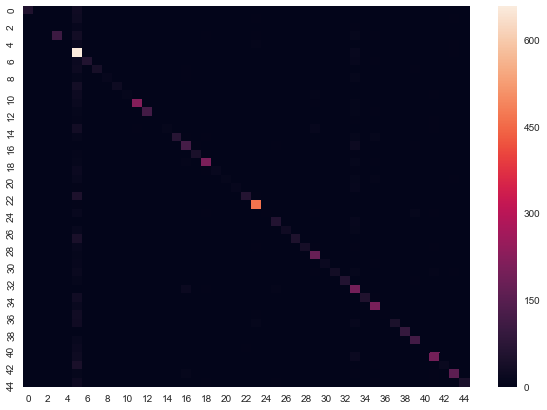

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

#split data into test and train sets
trainBody, testBody, trainBody_labels, testBody_labels = train_test_split(bodyMatrix, y_raw, test_size=0.10)

#fit model to train data
clfNB = MultinomialNB().fit(trainBody, trainBody_labels)

#predict on test data
predictionsNB = clfNB.predict(testBody)

#print results
print("Results with Naive Bayes:")
print("Accuracy: {0:0.3f} %".format(np.mean(predictionsNB == testBody_labels)*100))

printConfusionHeatmap(testBody_labels, predictionsNB, len(y_labels))

## Linear SVM Classification

Linear SVMs are highly regarded in natural language processing because it is one of the highest-performing classical machine learning models available. We see an increase in accuracy over the Naive Bayes model when using the Linear SVM. 

Results with Linear SVM:
Accuracy: 97.988 %


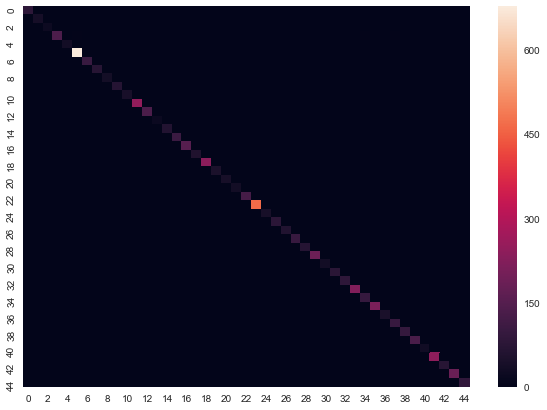

In [19]:
from sklearn import svm

#fit model to train data
clfSVM = svm.LinearSVC().fit(trainBody, trainBody_labels)

#predict on test data 
predictionsSVM = clfSVM.predict(testBody)

#print results 
print("Results with Linear SVM:")
print("Accuracy: {0:0.3f} %".format(np.mean(predictionsSVM == testBody_labels)*100))

printConfusionHeatmap(testBody_labels, predictionsSVM, len(y_labels))

## Multi-Layer Perceptron 

Neural methods have been shown to outperform classical machine learning in text-classification tasks. Here we use a multi-layer perceptron from sklearn with a standard one layer with 100 hidden units. 

Results with Multi-Layer Perceptron:
Accuracy: 97.932 %


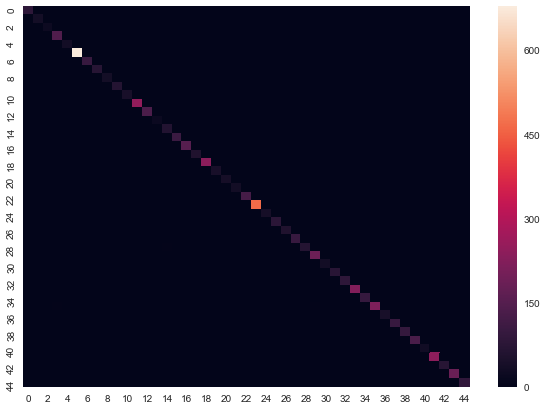

In [20]:
from sklearn.neural_network import MLPClassifier

#fit model to train data
clfMLP = MLPClassifier().fit(trainBody, trainBody_labels)

#predict on test data
predictionsMLP = clfMLP.predict(testBody)

#print results
print("Results with Multi-Layer Perceptron:")
print("Accuracy: {0:0.3f} %".format(np.mean(predictionsMLP == testBody_labels)*100))

printConfusionHeatmap(testBody_labels, predictionsMLP, len(y_labels))